In [1]:
import numpy as np
import loompy
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import os

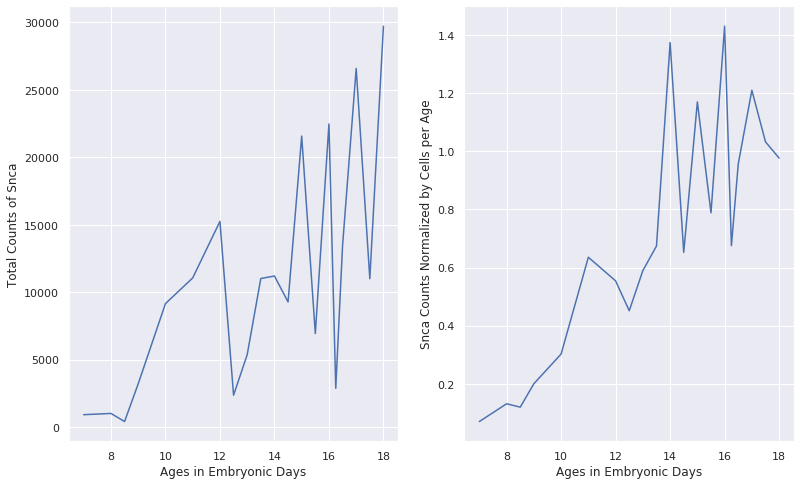

In [9]:
genename = "Snca"
df_small, ages, classes = load_data(genename)

counts_per_age_vector = calculate_total_counts_per_age(df_small, ages, genename)

fig, axes = plt.subplots(1, 2)

sns.set(font_scale = 1, rc={"figure.figsize":(13, 8)})
sns.lineplot(ax = axes[0], data=counts_per_age_vector, x = "Ages in Embryonic Days", y = "Total Counts of %s" %genename)

sns.set(font_scale = 1, rc={"figure.figsize":(13, 8)})
sns.lineplot(ax = axes[1], data=counts_per_age_vector, x = "Ages in Embryonic Days", y = "%s Counts Normalized by Cells per Age" %genename)


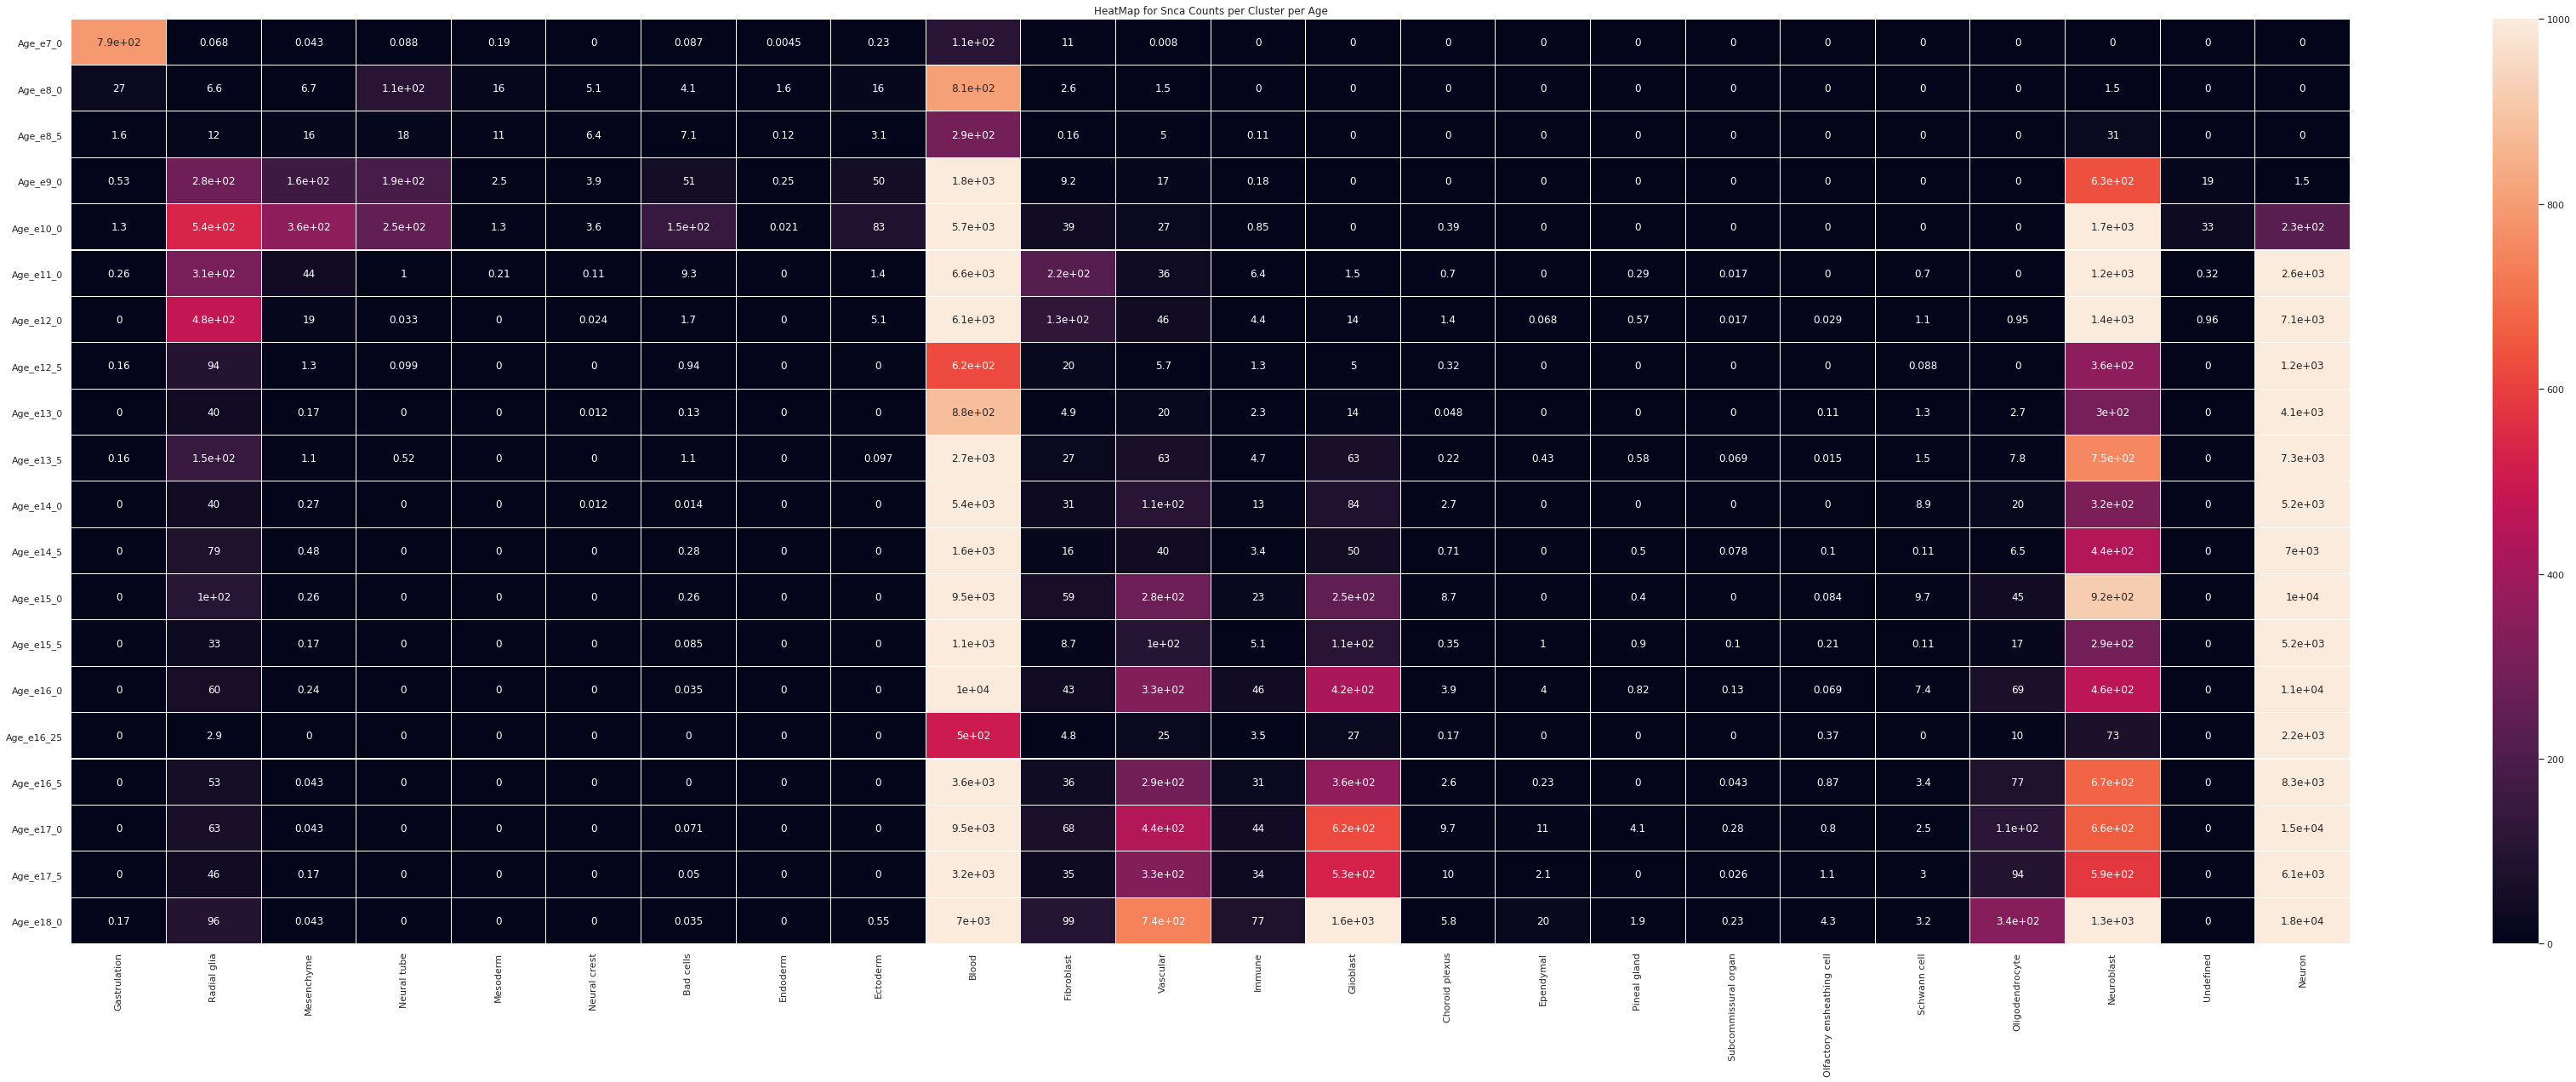

In [10]:
counts_per_class_per_age  = get_counts_per_class_per_age(df_small, ages, classes, genename)

plt.figure(figsize=(60,20))
heat_map = sns.heatmap(counts_per_class_per_age, linewidth = 0.1 , annot = True, vmax = 1000)
plt.title( "HeatMap for %s Counts per Cluster per Age" %genename )
plt.show()

# Load Data Function 

In [2]:

def load_data(genename):

    ds_dev = loompy.connect("dev_all.agg.loom", validate = False)

    CountData = pd.DataFrame(data = ds_dev[:,:], index = ds_dev.ra.Gene, columns=ds_dev.ca.ClusterName)

    genename_counts_per_cluster = CountData.loc[genename,:] #get mean counts per cell from specified Gene per Cluster

    ages = ds_dev.ca.keys()[0:20] #get ages from Data
    ages = ages[-4:] +  ages[:-4] # right order of Ages

    classes = pd.DataFrame(ds_dev.ca.Class, index = ds_dev.ca.ClusterName) #get classes of cells
    

    metadata = {}

    #Make Metadata DataFrame
    for i in ages:
        new = {i : ds_dev.ca[i]}
        metadata.update(new)
    metadata = pd.DataFrame(metadata, index = ds_dev.ca.ClusterName).T
    df = metadata.append(CountData)

    # Make DataFrame with all the Data + Metadata
    df_small = metadata.append(genename_counts_per_cluster)
    df_small = df_small.append(classes.T)
    df_small = df_small.T
    
    return df_small, ages, classes 



# Calculate Total Number of Counts for specific Gene per Age Function

In [3]:
def calculate_total_counts_per_age(df_small, ages, genename):
    #total counts
    counts_per_age_vector = np.zeros(len(ages))
    counts_per_cluster_per_age = np.zeros([len(ages),df_small.shape[0]])
    number_of_cells_per_age = np.zeros(len(ages))
    j = 0
    for i in ages:
        for k in range(df_small.shape[0]):
            counts_per_cluster_per_age[j,k] = df_small[i][k]*df_small[genename][k]
            counts_per_age_vector[j] += counts_per_cluster_per_age[j,k] 
            number_of_cells_per_age[j] += df_small[i][k]
        j+= 1
    ages_number = [7,8, 8.5 ,9,10,11,12, 12.5 ,13, 13.5, 14, 14.5, 15, 15.5 ,16, 16.25, 16.5, 17, 17.5, 18]
    counts_per_age_vector = pd.DataFrame(counts_per_age_vector, index = ages, columns = ["Total Counts of %s" %genename])
    age_df = pd.DataFrame(ages_number, index=ages, columns=["Ages in Embryonic Days"])
    counts_per_age_vector = pd.concat([counts_per_age_vector, age_df], axis=1)
    #normalized per cells per age 
    counts_per_age_normalized  = np.zeros(len(ages)) 
    j = 0 
    for i in ages:
        counts_per_age_normalized[j] = counts_per_age_vector["Total Counts of %s" %genename][j]/number_of_cells_per_age[j]
        j += 1
    counts_per_age_normalized = pd.DataFrame(counts_per_age_normalized, index=ages, columns=["%s Counts Normalized by Cells per Age" %genename])
    counts_per_age_vector = pd.concat([counts_per_age_vector, counts_per_age_normalized], axis=1)

    
    return counts_per_age_vector

# Get Counts per Class per Age Function

In [4]:
def get_counts_per_class_per_age(df_small, ages, classes, genename):
    classes_unique = classes[0].unique()
    counts_per_class_per_age = np.zeros([classes_unique.shape[0],len(ages)])
    counts_per_class_per_age = pd.DataFrame(counts_per_class_per_age, index = classes_unique, columns = ages).T

    j = 0
    for i in ages:
        for k in range(df_small.shape[0]):
            current_class = classes[0][k]
            counts_per_class_per_age[current_class][j] += df_small[i][k]*df_small[genename][k]
        j+= 1
        
    return counts_per_class_per_age

# Additional Stuff

In [79]:
number_of_cells_per_cluster = np.zeros(df_small.shape[0])
for i in range(df_small.shape[0]):
    for k in ages: 
        number_of_cells_per_cluster[i] += df_small[k][i]
number_of_cells_total = np.sum(number_of_cells_per_cluster)

# Get Ages of Cells as Index and plot genename Counts per Age again based on SC Data

In [59]:
ds_single_cells = loompy.connect("dev_all.loom", validate = False)
CountData_sc = pd.DataFrame(data = ds_single_cells[:,:], index = ds_single_cells.ra.Gene, columns=ds_single_cells.ca.ClusterName)
genename_counts_per_cell = CountData_sc.loc[genename,:]

CountData_sc_ages = pd.DataFrame(data = ds_single_cells[:,:], index = ds_single_cells.ra.Gene, columns=ds_single_cells.ca.Age)

In [61]:
CountData_sc_ages_genename = CountData_sc_ages.loc[genename,:]
counts_per_age_vector_sc = np.zeros(len(ages))
j = 0 
ages_modified = [f[4:] for f in ages]
ages_modified = [f.replace("_",".") for f in ages_modified]
for i in ages_modified: 
    counts_per_age_vector_sc[j] = np.sum(CountData_sc_ages_genename[i])
    j += 1
counts_per_age_vector_sc = pd.DataFrame(counts_per_age_vector_sc, index = ages_modified, columns = ["Total Counts of genename"])
age_df = pd.DataFrame(ages_number, index=ages_modified, columns=["Ages in Embryonic Days"])
counts_per_age_vector_sc = pd.concat([counts_per_age_vector_sc, age_df], axis=1)

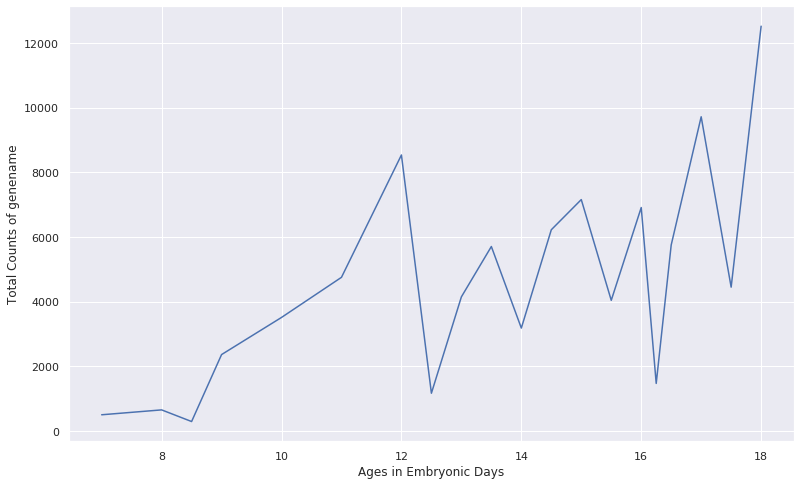

In [62]:
sns.set(font_scale = 1, rc={"figure.figsize":(13, 8)})
sns.lineplot(data=counts_per_age_vector_sc, x = "Ages in Embryonic Days", y = "Total Counts of genename")

# Normalize per Age 

In [63]:
cells_per_age = np.zeros(len(ages)) 
counts_per_age_normalized  = np.zeros(len(ages)) 
j = 0 
for i in ages_modified:
    cells_per_age[j] = CountData_sc_ages_genename[i].shape[0]
    counts_per_age_normalized[j] = counts_per_age_vector_sc["Total Counts of genename"][j]/cells_per_age[j]
    j += 1
counts_per_age_normalized = pd.DataFrame(counts_per_age_normalized, index=ages_modified, columns=["Counts Normalized by Cells per Age"])
counts_per_age_vector_sc = pd.concat([counts_per_age_vector_sc, counts_per_age_normalized], axis=1)

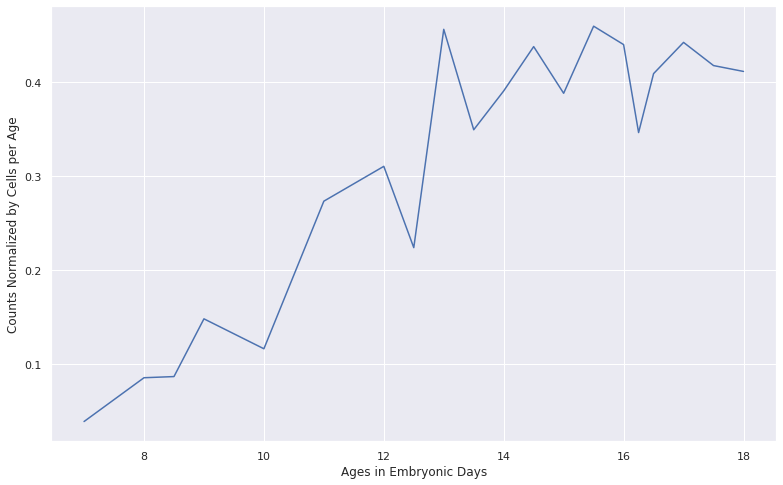

In [64]:
sns.set(font_scale = 1, rc={"figure.figsize":(13, 8)})
sns.lineplot(data=counts_per_age_vector_sc, x = "Ages in Embryonic Days", y = "Counts Normalized by Cells per Age")

In [108]:
df_small

,Age_e7_0,Age_e8_0,Age_e8_5,Age_e9_0,Age_e10_0,Age_e11_0,Age_e12_0,Age_e12_5,Age_e13_0,Age_e13_5,...,Age_e15_0,Age_e15_5,Age_e16_0,Age_e16_25,Age_e16_5,Age_e17_0,Age_e17_5,Age_e18_0,Dyrk1a,0
ParEndo,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.363636,Gastrulation
nan,22.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.423077,Gastrulation
TrophEct,438.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.191781,Gastrulation
FGut4,1.0,48.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.306122,Gastrulation
FGut1,22.0,56.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012821,Gastrulation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Neur793,0.0,0.0,0.0,0.0,0.0,5.0,6.0,6.0,0.0,10.0,...,4.0,5.0,25.0,0.0,1.0,46.0,0.0,20.0,0.083916,Neuron
Neur794,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,1.0,11.0,0.0,0.0,29.0,0.0,20.0,0.142857,Neuron
Neur795,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,...,0.0,0.0,14.0,0.0,0.0,29.0,1.0,9.0,0.017544,Neuron
Neur796,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,12.0,1.0,13.0,0.241379,Neuron
